<a href="https://colab.research.google.com/github/aborundiya/NeuralNetwork/blob/master/ComparisonOfAllGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np

In [0]:
class SN:

  def __init__(self, w_init, b_init, algo ):
    self.w = w_init
    self.b = b_init
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.algo = algo
  
  def sigmoid(self, x, w = None, b = None ):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1.0 / ( 1.0 + np.exp(-(w * x + b )))
  
  def error(self, X, Y, w = None , b = None):
    if w is None:
      w = self.w
    if b is None: 
      b = self.b
    err = 0 
    for x, y in zip(X,Y):
      err += 0.5 * (self.sigmoid(x, w , b ) - y) ** 2
    return err
  
  def grad_w( self, x ,y, w = None, b = None):
    if w is None:
      w =self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred - y) * y_pred * (1 - y_pred) * x 
  
  def grad_b( self, x ,y, w = None, b = None):
    if w is None:
      w =self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred - y) * y_pred * (1 - y_pred)

  def fit( self, X, Y, epochs = 100, eta = 0.01, gamma = 0.9,
          mini_batch_size =100, eps = 1e-8 , beta = 0.9, beta1 = 0.9, beta2 =0.9):
    self.w_h = []
    self.b_h = []
    self.e_h = []      
    self.X = X 
    self.Y = Y

    if self.algo == "GD": 
      for i in range(epochs):
        dw , db = 0 , 0
        for x, y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        self.w -= eta * dw / X.shape[0]
        self.b -= eta * db / X.shape[0]
        self.append_log()
    
    if self.algo == "Momentum":
      v_w , v_b = 0 , 0 
      for i in range(epochs):
        dw , db = 0 , 0 
        for x ,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        
        v_w = gamma * v_w + eta * dw / X.shape[0] 
        v_b = gamma * v_b + eta * db / X.shape[0]
        self.w -= v_w 
        self.b -= v_b
        self.append_log()


  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X,self.Y))

In [0]:
X = np.array([0.5,2.5])
Y = np.array([0.2,0.9])

algo = "GD"

w_init = -2 
b_init = -2

epochs = 1000
eta = 1 

w_min = -7 
w_max = 5 

b_min = -7
b_max = 5 

animation_frames = 20 
plot_3d = False 
plot_2d = True 

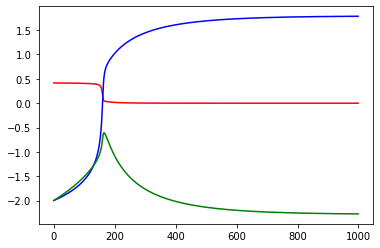

In [59]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs , eta )
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')

plt.show()

In [0]:
if plot_3d : 
  W = np.linspace(w_min, w_max, 256)
  B = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, B)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(WW, BB, Z, rstride=3, cstride=3, alpha=0.5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  cset = ax.contourf(WW, BB, Z, 25, zdir='z', offset=-1, alpha=0.6, cmap=cm.coolwarm)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  ax.set_zlabel('error')
  ax.set_zlim(-1, np.max(Z))
  ax.view_init (elev=25, azim=-75) # azim = -20
  ax.dist=12  
  title = ax.set_title('Epoch 0')
  



In [0]:
def plot_animate_3d(i):
  i = int( i * (epoch/animation_frames ))
  line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line1.set_3d_properties(sn.e_h[:i+1])
  line2.set_data(sn.w_h[:i+1],sn.b_h[:i+1])
  line2.set_3d_properties(np.zeros(i+1)-1)
  title.set_text('Epoch : {:d}, Error :{:.4f}'.format(i,sn.e_h[i]))
  return line1, line2 , title 



In [0]:
if plot_3d: 
  i = 0
  line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], color='black',marker='.')
  line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1) - 1, color='red', marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_3d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim


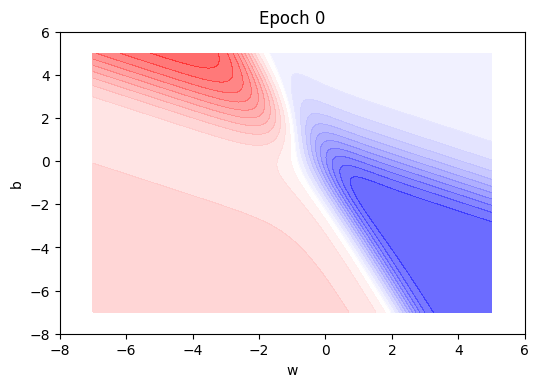

In [63]:
if plot_2d:
  W = np.linspace(w_min, w_max, 256)
  B = np.linspace(w_min, w_max, 256)
  WW, BB = np.meshgrid(W,B)
  Z = sn.error(X,Y,WW,BB)

  fig = plt.figure(dpi=100)
  ax = plt.subplot(111)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  title = ax.set_title('Epoch 0')
  cset = plt.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)
  plt.show()


In [0]:
def plot_animate_2d(i):
  i = int(i*(epochs/animation_frames))
  line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  print("inside plot")
  return line, title


In [75]:
if plot_2d: 
  print("inside animation")
  i = 0
  line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color='black',marker='.')
  anim = animation.FuncAnimation(fig, func = plot_animate_2d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim
  plt.show()

inside animation
